In [1]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
%matplotlib inline
sns.set_palette("Set2")

In [3]:
#load data
raw_ds=pd.read_csv(r"..\data\interim\AD_MCI2.csv")
dd=pd.read_csv(r"..\docs\rdd_datadictionary_uds.csv")

C:\Users\viceva\miniconda3\envs\AD\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20,22,24,26,41,44,46,48,61,63,65,67,69,71,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,165,176,179,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,266,272,397,399,401,423,432,445,454,575,600,636,652,672,677,689,706,780,791,793,795,797,803,864,919,920,921,929,930,931,932,942,964,967,970) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## In this notebook: Focus 1st on most recent visit from demented diagnosis, drop nan columns


In [4]:
pd.options.display.max_colwidth = 300
print(dd.loc[dd.VariableName=='TOBAC30'])

    VariableName Form           VariableType  \
123      TOBAC30   a5  Original UDS question   

                       ShortDescriptor              DataType  \
123  Smoked cigarettes in last 30 days  Numeric longitudinal   

                                                                                                                                                            AllowableCodes  
123   0 = No\r\n1 = Yes\r\n9 = Unknown\r\n- 4 =  Not available: UDS form submitted did not collect data in this way, or a skip pattern precludes response to this question  


In [5]:
#drop rows withvisit_interval == nan; 
#drop every row per id but latest recorded
print(raw_ds.shape)
one_ts=raw_ds[raw_ds['visit_interval'].notna()]
print(one_ts.shape)
grouped=one_ts.groupby('NACCID')
max_i = grouped['NACCVNUM'].idxmax()
one_ts=one_ts[one_ts.index.isin(max_i.values)]
print(one_ts.shape)


(18774, 975)
(14499, 975)
(6156, 975)


In [6]:
one_ts

,Unnamed: 0,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPPOTH2,NPCOTH2,NPOTH2X,NPPOTH3,NPCOTH3,NPOTH3X,visitdate,visit_interval,target,NACCID
0,26,289,I,1.0,2,13,2008,1,4,2,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2008-02-13,427.0,1.0,NACC004445
1,124,289,I,3.0,6,6,2016,1,2,2,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2016-06-06,474.0,1.0,NACC031269
2,163,289,I,2.0,2,27,2009,1,6,6,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2009-02-27,413.0,1.0,NACC035447
4,178,289,I,2.0,7,16,2014,1,3,3,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2014-07-16,327.0,1.0,NACC036218
5,208,289,I,2.0,7,5,2011,1,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-05,264.0,1.0,NACC040968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18759,152579,9661,F,2.0,2,5,2008,3,3,3,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2008-02-05,370.0,0.0,NACC961914
18761,152607,9661,F,3.0,5,24,2019,2,2,2,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2019-05-24,723.0,0.0,NACC968945
18764,152628,9661,F,1.0,12,4,2007,3,7,4,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2007-12-04,351.0,0.0,NACC975578
18767,152673,9661,F,2.0,4,2,2013,8,9,9,...,-4.0,-4.0,NaN,-4.0,-4.0,NaN,2013-04-02,315.0,0.0,NACC985081


In [7]:
#sanity check
one_ts['NACCID'].nunique() == one_ts['NACCID'].size

True

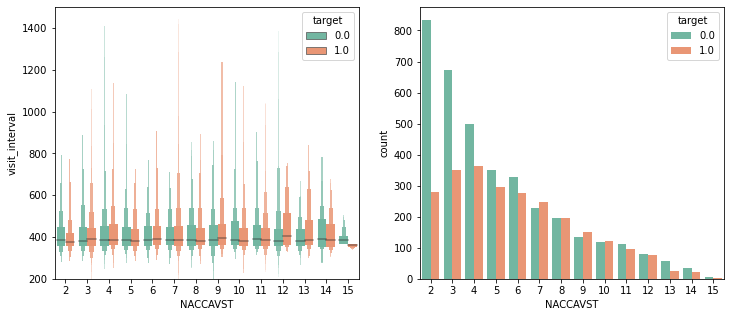

In [8]:
#recheck distros
f, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxenplot(x="NACCAVST", y="visit_interval", hue="target",showfliers=0,
            data=one_ts,ax=axes[0]); axes[0].set(ylim=(200, 1500))

sns.countplot(x="NACCAVST", hue="target",
            data=one_ts.groupby(['NACCID']).mean(),ax=axes[1]);
#g.set_xticklabels(g.get_xticklabels(),rotation=45)
labels = [label.get_text() for label in axes[1].get_xticklabels()];
axes[1].set_xticklabels(map(lambda x: "{:g}".format(float(x)), labels));

In [9]:
one_ts=one_ts.dropna(axis=1,how='all')
one_ts.describe

<bound method NDFrame.describe of        Unnamed: 0  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  \
0              26      289      I      1.0        2        13     2008   
1             124      289      I      3.0        6         6     2016   
2             163      289      I      2.0        2        27     2009   
4             178      289      I      2.0        7        16     2014   
5             208      289      I      2.0        7         5     2011   
...           ...      ...    ...      ...      ...       ...      ...   
18759      152579     9661      F      2.0        2         5     2008   
18761      152607     9661      F      3.0        5        24     2019   
18764      152628     9661      F      1.0       12         4     2007   
18767      152673     9661      F      2.0        4         2     2013   
18773      152681     9661      F      2.0        8        27     2009   

       NACCVNUM  NACCAVST  NACCNVST  ...  NPPOTH2  NPCOTH2  NPOTH2X  NPPOTH3 

In [10]:
#nan time
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Missing%'] = (df.isnull().sum().values/df.shape[0])*100
    summary['Uniques'] = df.nunique().values
    summary=summary.sort_values(by=['Missing','Uniques'], ascending=[False, False])
    return summary

In [11]:
#what are the nulls
pd.set_option('display.min_rows', 500)
summary(one_ts)

,Name,dtypes,Missing,Missing%,Uniques
26,RACETERX,object,6155,99.983756,1
104,DRUG30,object,6155,99.983756,1
105,DRUG31,object,6155,99.983756,1
106,DRUG32,object,6155,99.983756,1
216,TRESTFAX,object,6155,99.983756,1
103,DRUG29,object,6154,99.967511,2
212,SPEECHX,object,6154,99.967511,2
214,FACEXPX,object,6154,99.967511,2
218,TRESTRHX,object,6154,99.967511,2
222,TRESTRFX,object,6154,99.967511,2


In [12]:
#handle the drugs
one_ts['drug_count']=one_ts.loc[:,one_ts.columns.str.contains('DRUG')].apply(lambda x: x.count(), axis=1).copy()
drugs=one_ts.loc[:,one_ts.columns.str.contains('DRUG')]
#and drop the drugs
one_ts=one_ts.loc[:,~one_ts.columns.str.contains('DRUG')]

drugs.shape

C:\Users\viceva\miniconda3\envs\AD\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(6156, 32)

In [13]:
#forms
forms=one_ts[['NACCID','PACKET','FORMVER']].copy()
dd.Form.unique()
form_dict={'header':'patient info','milestones':'milestones','other':'other measures','a1':'Subject Demographics','a2':'Co-participant Demographics','a3':'Family History','a4':'Medications','a5':'Health History','b1':'Physical','b2':'HIS and CVD','b3':'Unified Parkinson’s Disease Rating Scale','b4':'CDR® Plus NACC FTLD','b5':'Neuropsychiatric Inventory Questionnaire (NPI-Q)','b6':'Geriatric Depression Scale (GDS)','b7':'Functional Activities Questionnaire(FAQ)','b8':'Physical/Neurological Exam Findings','b9':'Clinician Judgment of Symptoms','c1c2':'Neuropsychological Battery','c1':'Neuropsychological Battery','c2':'Neuropsychological Battery','d1':'Clinician Diagnosis','d2':'Clinician-assessed Medical Conditions'}


In [14]:
#drop all other cols (ending with X)
one_ts = one_ts.loc[:,~one_ts.columns.str.endswith('X')]
#or go ahead and drop all columns with more than 20% nan
one_ts=one_ts[one_ts.columns[one_ts.isnull().mean() < 0.2]]
one_ts=one_ts[one_ts.columns[one_ts.nunique() < 1000]]

In [15]:
def plt_cat(df,target):
    ix = 1
    fig = plt.figure(figsize = (15,10))
    for c in list(df.columns):
        if ix <= 3:
            if c != target:
                ax1 = fig.add_subplot(2,3,ix)
                #sns.countplot(data = df, x=c, hue=target, ax = ax1)
                df1 = df.groupby(target)[c].value_counts(normalize=True)
                df1 = df1.rename('norm').reset_index()
                sns.barplot(x=c,y='norm',hue=target,data=df1,ax = ax1)
                
                ax2 = fig.add_subplot(2,3,ix+3)
                #sns.violinplot(data=df, x=target, y=c, split=True, ax=ax2)
                sns.boxenplot(data=df, x=target, y=c, ax=ax2)

        ix = ix +1
        if ix == 4: 
            fig = plt.figure(figsize = (15,10))
            ix =1

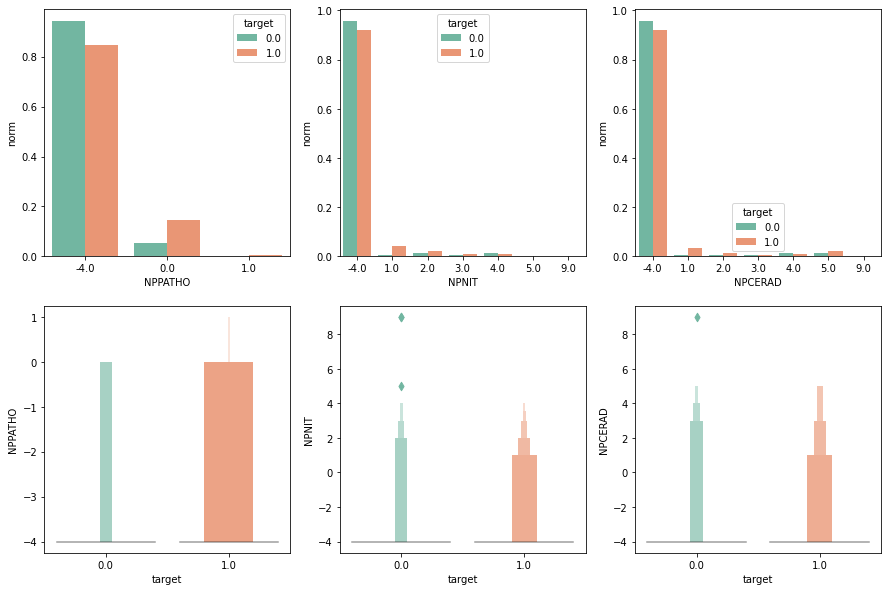

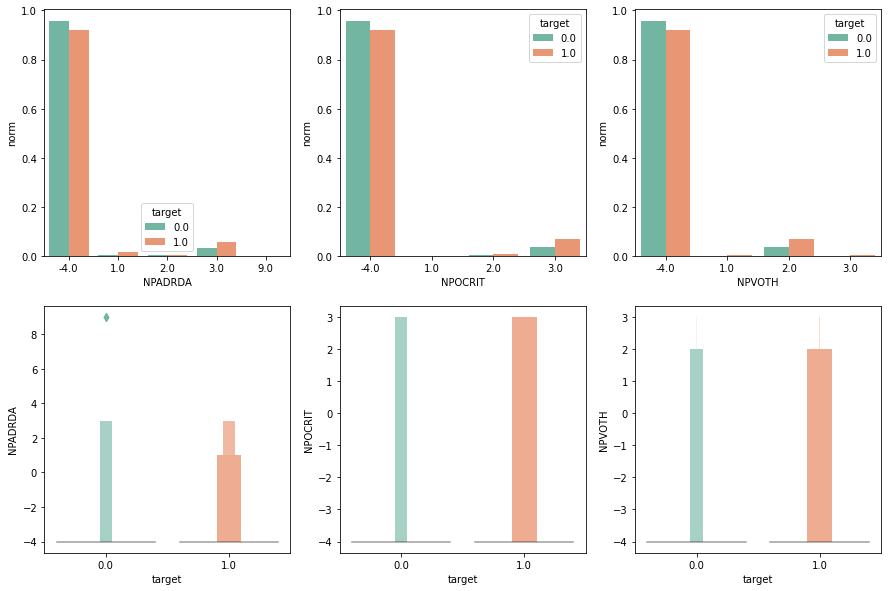

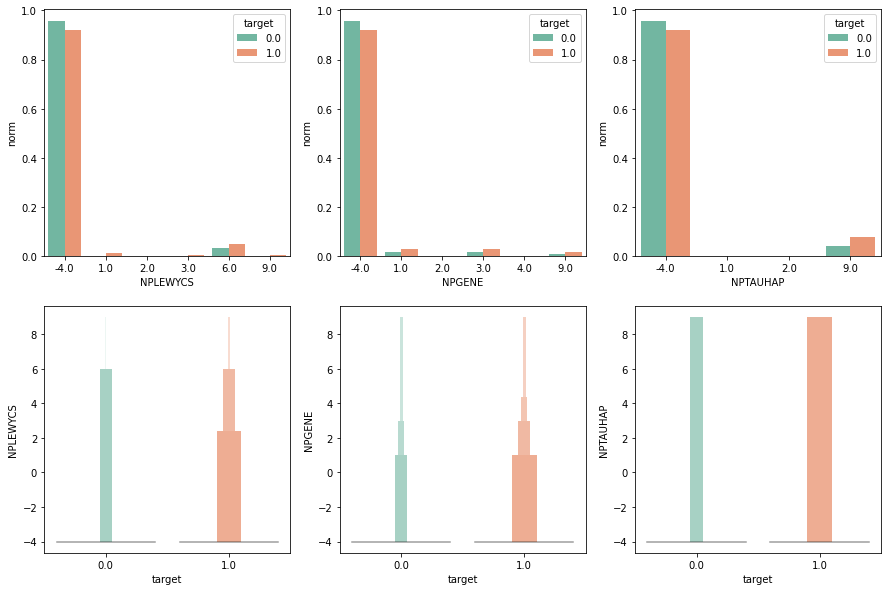

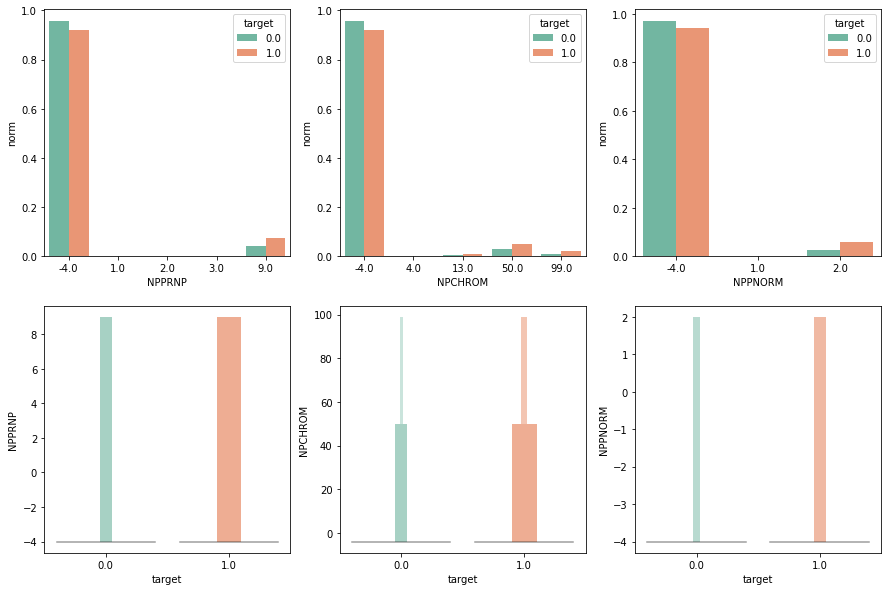

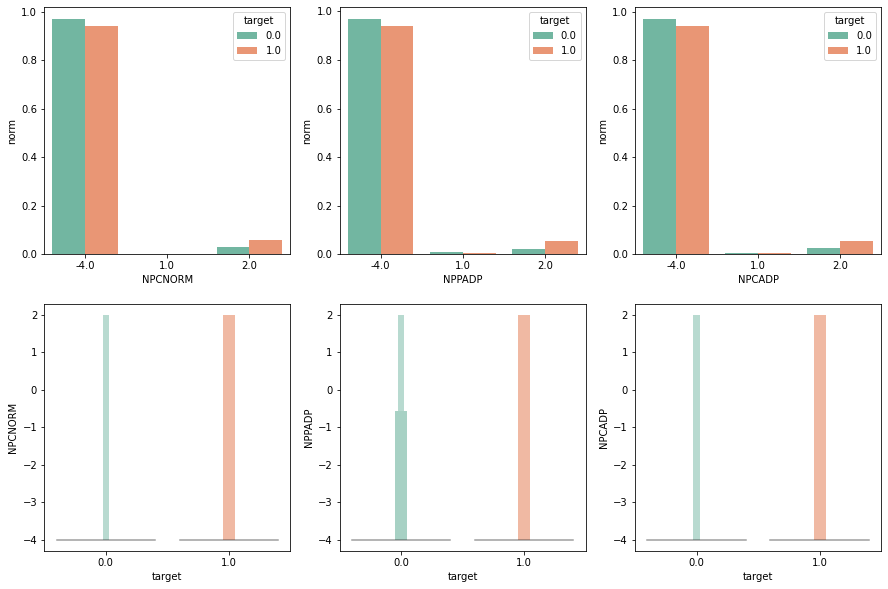

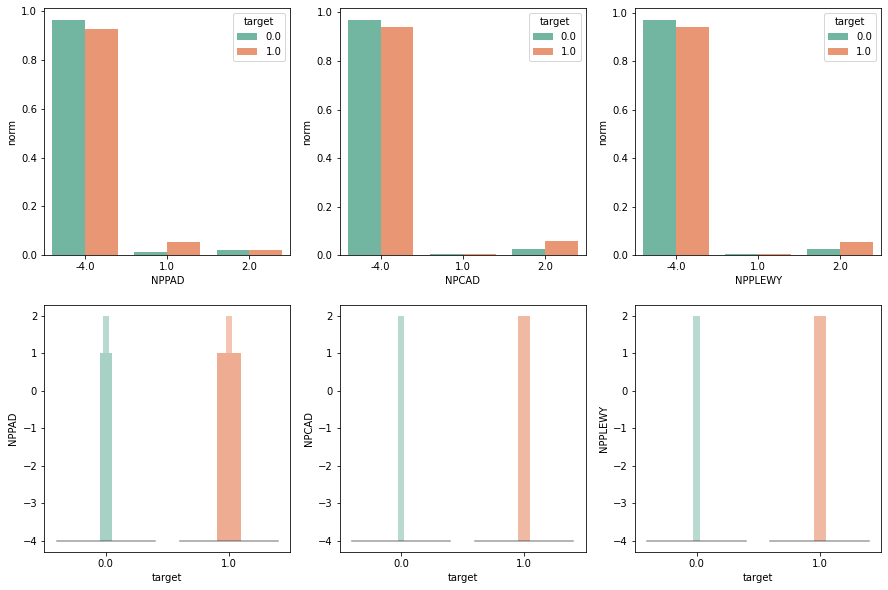

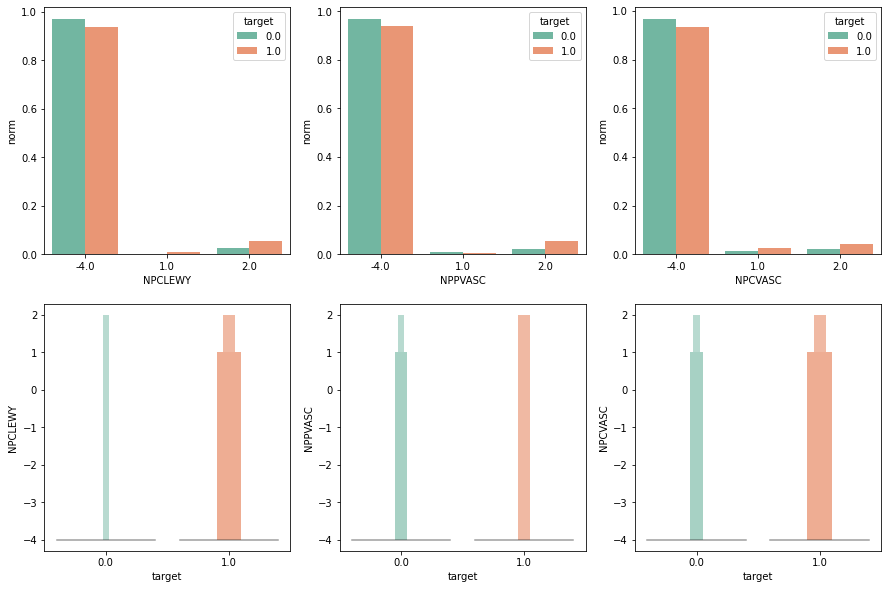

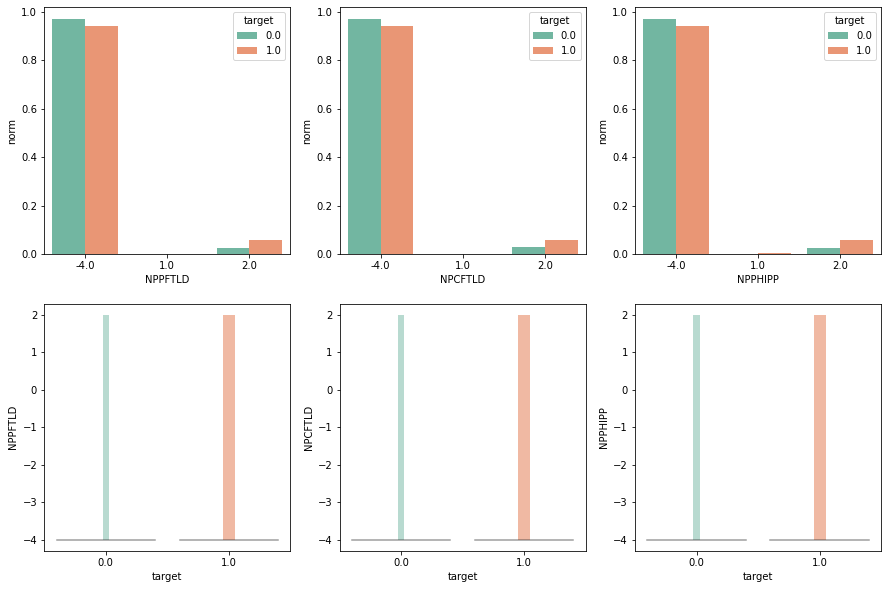

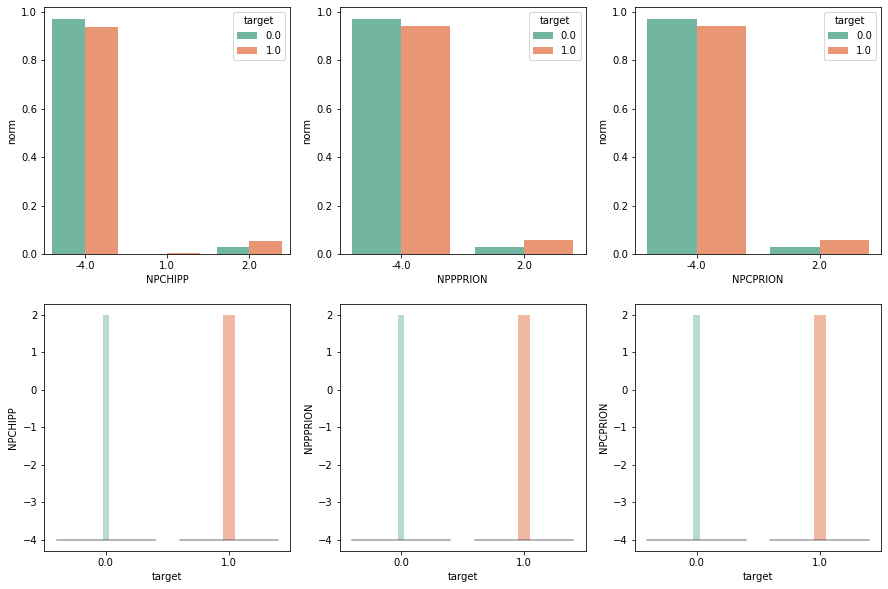

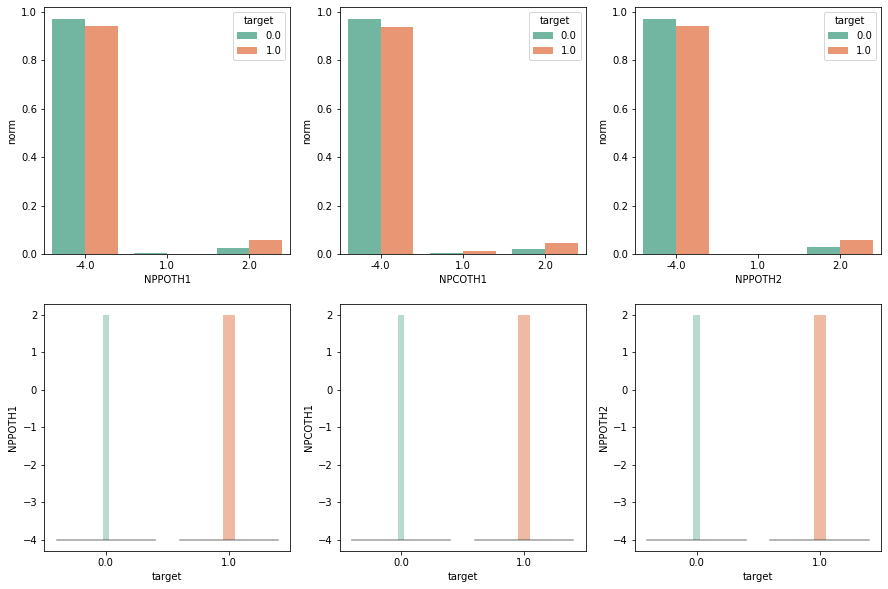

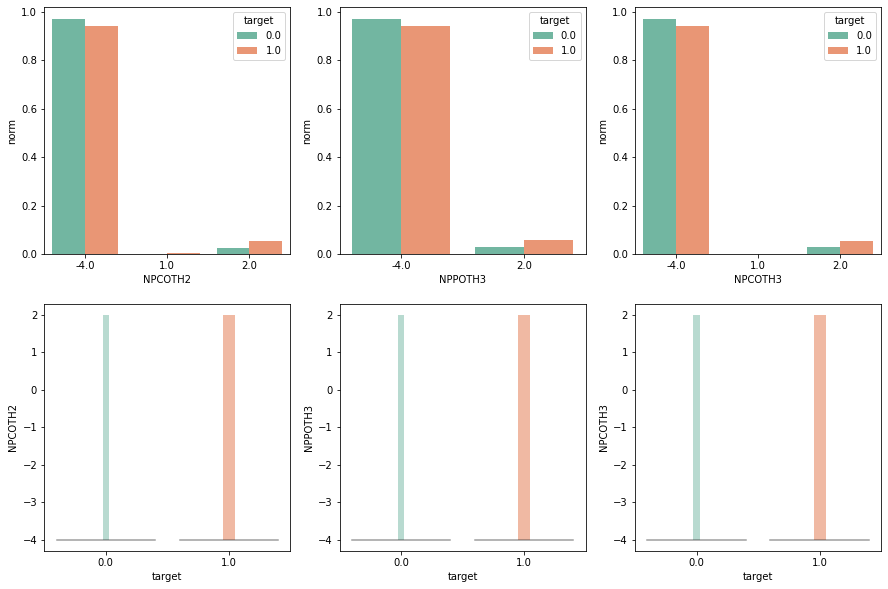

<Figure size 1080x720 with 0 Axes>

In [16]:
#lets plot the remaing variables with nans
t=one_ts[one_ts.columns[one_ts.isnull().mean() > 0]].copy()
t['target']=one_ts["target"]
plt_cat(t,"target")

In [17]:
#useless drop function
def drop_useless(df, cols):
    for c in cols:
        if c in df.columns:
            df.drop(c,axis=1,inplace=True)

In [18]:
#All these nan columns have the majority of data unavailable (-4) as they come from a merged table of brain autopsy details and majority of patients are alive or didn't donate their brain.
#Therefore discard and let's look at the rest
one_ts=one_ts[one_ts.columns[one_ts.isnull().mean() == 0]]
#from here we can take out those with -4 and 0, vars with one number only, and vars that are part of the neuropathology database and most of genomic
one_ts=one_ts.loc[:,~one_ts.columns.str.startswith(('ADGC','NGDS'))]
cols=one_ts.loc[:,'NPFORMVER':'NACCINT'].columns
useless=pd.Index(['NCDSWEAC', 'NACCNCRD'])
cols=cols.append(useless)
drop_useless(one_ts,cols)

one_ts.drop(one_ts.columns[one_ts.nunique() == 1],axis=1,inplace=True)
#where all is -4 and another number
one_ts.drop(one_ts.columns[one_ts.nunique()==2] & one_ts.columns[one_ts.isin([-4]).any()],axis=1,inplace=True) #maybe dont do this one, predictability?

In [19]:
#where there's only -4 unique per target?
g = one_ts.groupby('target').agg(['unique'])
g

,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,NACCREAS,...,NACCPCSF,NACCTCSF,NACCMRSA,NACCNMRI,NACCAPSA,NACCNAPA,NACCAPOE,NACCNE4S,visit_interval,drug_count
,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,...,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique
target,,,,,,,,,,,,,,,,,,,,,
0.0,"[289, 354, 490, 911, 943, 1018, 1354, 1416, 2096, 2125, 2289, 2578, 2958, 3630, 3697, 3964, 3966, 4032, 4347, 4935, 4967, 5310, 5452, 5783, 5897, 6061, 6499, 6518, 6713, 8354, 8361, 8646, 8658, 8660, 8683, 8974, 9637, 9661]","[I, T, F]","[3.0, 2.0, 1.0]","[2, 6, 3, 4, 11, 8, 10, 9, 12, 1, 5, 7]","[9, 13, 18, 26, 7, 28, 30, 17, 23, 19, 8, 20, 2, 3, 24, 11, 1, 14, 15, 6, 31, 22, 16, 27, 25, 21, 4, 12, 10, 5, 29]","[2017, 2016, 2020, 2018, 2019, 2010, 2014, 2013, 2009, 2007, 2012, 2015, 2008, 2011, 2006, 2005]","[1, 2, 10, 5, 6, 3, 4, 7, 12, 9, 8, 13, 11, 14, 15]","[3, 2, 10, 5, 6, 4, 7, 13, 8, 11, 12, 9, 14, 15]","[3, 1, 8, 5, 6, 4, 2, 9, 7, 12, 10, 11, 13, 14, 15]","[1, 7, 2, 9]",...,"[0, 1]","[0, 1]","[0, 1]","[0, 1, 3, 2, 4, 10, 5, 9, 6, 8]","[0, 1]","[0, 1]","[1, 2, 4, 3, 9, 5, 6]","[0, 1, 2, 9]","[330.0, 365.0, 534.0, 533.0, 339.0, 344.0, 474.0, 368.0, 468.0, 1093.0, 578.0, 722.0, 414.0, 392.0, 336.0, 375.0, 335.0, 650.0, 539.0, 469.0, 470.0, 450.0, 316.0, 402.0, 446.0, 359.0, 377.0, 725.0, 434.0, 350.0, 259.0, 1155.0, 323.0, 492.0, 798.0, 1635.0, 462.0, 859.0, 343.0, 364.0, 430.0, 408.0...","[6, 14, 7, 5, 11, 4, 3, 9, 8, 10, 1, 2, 0, 17, 21, 18, 13, 20, 16, 15, 24, 22, 23, 19, 12, 26, 27, 29, 28, 25]"
1.0,"[289, 354, 490, 911, 943, 1018, 1354, 1416, 2096, 2125, 2289, 2578, 2933, 2958, 3630, 3697, 3964, 3966, 4032, 4347, 4935, 4967, 5310, 5452, 5783, 5897, 6061, 6499, 6518, 6713, 8354, 8361, 8646, 8658, 8660, 8683, 8974, 9637, 9661]","[I, F, T]","[1.0, 3.0, 2.0]","[2, 6, 7, 9, 3, 10, 8, 5, 12, 4, 11, 1]","[13, 6, 27, 16, 5, 12, 21, 2, 1, 28, 10, 15, 31, 19, 18, 11, 22, 8, 25, 24, 14, 26, 17, 4, 29, 30, 3, 20, 7, 23, 9]","[2008, 2016, 2009, 2014, 2011, 2013, 2012, 2018, 2017, 2015, 2006, 2010, 2007, 2020, 2019, 2005]","[1, 5, 2, 3, 4, 7, 9, 10, 6, 12, 8, 11, 13, 14]","[4, 2, 6, 3, 5, 7, 8, 9, 10, 13, 12, 11, 14, 15]","[2, 6, 3, 4, 1, 7, 5, 9, 8, 13, 10, 11, 12, 14, 15]","[2, 7, 1, 9]",...,"[0, 1]","[0, 1]","[0, 1]","[0, 7, 1, 6, 4, 2, 10, 3, 5, 8, 9]","[0, 1]","[0, 1]","[1, 2, 3, 4, 5, 9, 6]","[0, 1, 2, 9]","[427.0, 474.0, 413.0, 327.0, 264.0, 438.0, 372.0, 490.0, 365.0, 349.0, 343.0, 273.0, 384.0, 406.0, 476.0, 386.0, 297.0, 445.0, 363.0, 419.0, 364.0, 500.0, 280.0, 287.0, 566.0, 397.0, 340.0, 686.0, 414.0, 252.0, 263.0, 411.0, 350.0, 493.0, 572.0, 1127.0, 291.0, 545.0, 385.0, 361.0, 987.0, 300.0, ...","[5, 4, 7, 8, 2, 3, 10, 15, 9, 1, 14, 6, 12, 13, 0, 11, 18, 17, 20, 16, 19, 27, 21, 22, 23, 25, 32, 24, 28]"


<AxesSubplot:xlabel='LOGIPREV', ylabel='norm'>

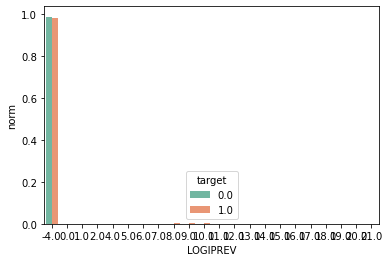

In [20]:
c='LOGIPREV'#'NACCAM'#NACCALZD
target='target'
df1 = one_ts.groupby(target)[c].value_counts(normalize=True)
df1 = df1.rename('norm').reset_index()
sns.barplot(x=c,y='norm',hue=target,data=df1)

In [21]:
#useless/dangerous by inspection %recheck
useless=['PACKET','FORMVER','NACCADC','VISITMO','VISITDAY','VISITYR','NACCVNUM','NACCCORE','NACCREAS','BIRTHMO','INBIRMO','INHISPOR','INRACE', 'INRASEC','INRATER','INEDUC','INKNOWN','NACCAMS','NACCFM','NACCFMS','NACCOM','NACCOMS','MACCFFTD','HATTMULT','HATTYEAR','NACCSTYR','TIAMULT','NACCTIYR','PDYR','PDOTHRYR','TBIYEAR','COGFLAGO','BEVHAGO','BEREMAGO', 'BEAGE','PARKAGE','MOAGE','ALSAGE','LOGIMO','LOGIDAY','LOFIYR','LOGIPREV','MOCAREAS','NORMCOG','DEMENTED','AMNDEM','PCA','NACCPPAG','PSPIF','NACCNRDY','NACCNRMO','NACCDSYR','NACCDSMO','NACCDSDY','NACCYOD','NACCMOD','LOGIYR','NACCIDEM','NACCDIED','NACCAUTP']

drop_useless(one_ts,useless)


## save cleaned db, drugs and forms here

In [23]:
one_ts=one_ts.loc[:, ~one_ts.columns.str.match('Unnamed')]
one_ts

,NACCAVST,NACCNVST,NACCREFR,BIRTHYR,HISPANIC,HISPOR,RACE,RACESEC,RACETER,PRIMLANG,...,NACCTCSF,NACCMRSA,NACCNMRI,NACCAPSA,NACCNAPA,NACCAPOE,NACCNE4S,visit_interval,target,drug_count
0,4,2,2,1920,0,88,5,88,88,1,...,0,0,0,0,0,1,0,427.0,1.0,5
1,2,2,2,1939,0,88,1,88,88,1,...,0,0,0,0,0,2,1,474.0,1.0,4
2,6,6,8,1932,0,88,5,88,88,3,...,0,0,0,0,0,1,0,413.0,1.0,7
4,3,3,2,1935,0,88,1,88,88,1,...,0,0,0,0,0,1,0,327.0,1.0,8
5,5,4,2,1935,0,88,1,88,88,1,...,0,0,0,0,0,2,1,264.0,1.0,2
6,3,2,2,1944,0,88,1,88,88,1,...,0,0,0,0,0,2,1,438.0,1.0,3
9,2,2,2,1927,0,88,5,88,88,1,...,0,0,0,0,0,3,0,372.0,1.0,10
10,2,2,2,1953,0,88,1,88,88,1,...,0,0,0,0,0,2,1,490.0,1.0,8
11,3,3,2,1959,0,88,1,88,88,1,...,0,0,0,0,0,4,2,365.0,1.0,4
16,6,6,2,1935,0,88,1,88,88,1,...,0,0,0,0,0,2,1,349.0,1.0,15


In [24]:
import json
with open('../data/processed/forms.txt', 'w') as outfile:
    json.dump(form_dict, outfile)
outfile.close() 
one_ts.to_csv('..\data\processed\prelim_clean.csv')
drugs.to_csv('..\data\processed\drugs.csv')
forms.to_csv('../data/processed/forms.csv')

In [ ]:
#numerical cols: usually more than 20 unique numbers
#numerical_cols=['NACCAVST','NACCNVST','BRTHYR','EDUC', 'INBIRYR','SMOKYRS','QUITSMOK','HEIGHT','WEIGHT']
numerical_cols=one_ts.columns[one_ts.nunique() > 10]
others=['MMSEORDA','MMSEORLO','PENTAGON','NACCNRYR']
numerical_cols=numerical_cols.append(pd.Index(others))

In [ ]:
numerical_cols

## save numerical cols here

In [ ]:
pd.Series(numerical_cols,index=numerical_cols).to_csv('../data/processed/numerical_cols.csv', header=False)

In [ ]:
#and plot
plt_cat(one_ts[one_ts.columns[~one_ts.columns.isin(numerical_cols)]],"target")

In [ ]:
#histogram of visit_interval
sns.distplot(one_ts["visit_interval"][one_ts["target"]==0])
sns.distplot(one_ts["visit_interval"][one_ts["target"]==1])
len(one_ts.select_dtypes(include=['int64','float64']))==one_ts.shape[0]#check if everything is numeric

In [ ]:
#pearson correl for visualization
n_ds =one_ts[numerical_cols]
sum_corr = n_ds.corr().sum().sort_values(ascending=False).index.values
plt.figure(figsize=(13, 13))
sns.heatmap(n_ds[sum_corr].corr())
#some variables are coding the same, we will have to drop: examples age & birthyear, drugnumber, bmi and weight


In [ ]:
#split numerical in training sets
X_train, X_test, y_train, y_test = train_test_split(n_ds, one_ts['target'], test_size=0.35, random_state=1)
# configure to select all features
fs = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
target_vec=fs.scores_

In [ ]:
def feature_drop(corr_matrix, target_vec):
    corr_features=[]
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.85:
                if target_vec[i] > target_vec[j]:
                    colname = corr_matrix.columns[j]
                else:
                    colname = corr_matrix.columns[i]

                corr_features.append(colname)
    return corr_features            


In [ ]:
to_drop_num=feature_drop(n_ds.corr(), target_vec)
drop_useless(one_ts, np.unique(to_drop_num))
drop_useless(n_ds, np.unique(to_drop_num))
up_numerical_cols = set(numerical_cols).difference(np.unique(to_drop_num))

len(to_drop_num)

In [ ]:
#plot numerical
temp=n_ds.copy()
temp['target']=one_ts['target']
plt_cat(temp,"target")


## some tree tests

In [ ]:
#quick tree
X_train, X_test, y_train, y_test = train_test_split(one_ts.drop(['target'], axis=1), one_ts['target'], test_size=0.35, random_state=1)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(model.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

In [ ]:
from sklearn import tree
tree.plot_tree(model);

In [ ]:
one_ts.columns[556]

In [ ]:
#feature selection
y= one_ts['target']
X = one_ts.drop('target', axis=1)
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


In [ ]:
c='NEWINF'#'NACCAM'#NACCALZD
target='target'
df1 = one_ts.groupby(target)[c].value_counts(normalize=True)
df1 = df1.rename('norm').reset_index()
sns.barplot(x=c,y='norm',hue=target,data=df1)

In [ ]:
res=feat_importances.nlargest(100).index

In [ ]:
#quick tree restricted
#quick tree
X_train, X_test, y_train, y_test = train_test_split(one_ts[res.to_list()], one_ts['target'], test_size=0.35, random_state=1)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(model.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

In [ ]:
# res taken
taken=one_ts[res.to_list()].drop(['NACCADMD','NACCAVST', 'NACCAM', 'NACCALZD','NACCALZP','INHISP','NEWINF'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(taken, one_ts['target'], test_size=0.5, random_state=1)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(model.score(X_test, y_test))
print(precision_score(y_test,y_pred))
recall_score(y_test,y_pred)

In [ ]:
sns.countplot(one_ts['target'])

## useless factor analyzer

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(one_ts)
kmo_model


In [ ]:
from factor_analyzer import analyze

fa = FactorAnalyzer(rotation=None)
fa.fit(one_ts)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

In [ ]:
plt.plot(range(1,one_ts.shape[1]+1),ev)
plt.xlim([0, 20])

In [ ]:
fa = FactorAnalyzer(10, rotation='varimax')
fa.fit(one_ts)
loads = fa.loadings_
print(loads)

In [ ]:
loads.shape

In [ ]:
filt_loads=np.argwhere(loads>.5)

In [ ]:
filt_loads.shape

In [ ]:
a=np.argmax(loads, axis=0)
a

In [ ]:
one_ts.columns[a]